In [ ]:
import subprocess
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# check if GPU is available
!nvidia-smi


Sat Jan 31 21:20:52 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# check nvcc version
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


## Part 1: Matrix Multiplication on the CPU

In [ ]:
%%writefile matrix_cpu.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

void matrixMultiplyCPU(float *A, float *B, float *C, int N) {
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            float sum = 0.0f;
            for (int k = 0; k < N; k++) {
                sum += A[i * N + k] * B[k * N + j];
            }
            C[i * N + j] = sum;
        }
    }
}

int main(int argc, char **argv){
    int N = (argc > 1) ? atoi(argv[1]) : 1024; // allow matrix size as input
    size_t size = N * N * sizeof(float);

    float *A = (float *)malloc(size);
    float *B = (float *)malloc(size);
    float *C = (float *)malloc(size);

    for (int i = 0; i < N * N; i++) {
        A[i] = rand() % 100 / 100.0f;
        B[i] = rand() % 100 / 100.0f;
    }

    clock_t start = clock();
    matrixMultiplyCPU(A, B, C, N);
    clock_t end = clock();

    double elasped = (double)(end - start) / CLOCKS_PER_SEC;
    printf("CPU execution time (N=%d): %.4f second\n", N, elasped);

    free(A); free(B); free(C);
    return 0;
}


Overwriting matrix_cpu.c


In [ ]:
!gcc matrix_cpu.c -o matrix_cpu -O2

In [ ]:
def run_time_comparison(n_list, command = './matrix_cpu'):
    time_list = []

    for n in n_list:
        run_cmd = subprocess.run([command, str(n)], capture_output=True, text=True)
        output = run_cmd.stdout
        print(output)
        time_str = output.split(':')[-1].strip().replace('second', 'sec')
        time_list.append(time_str)

    return time_list

In [ ]:
n_list = [2**k for k in range(6, 12)]
cpu_times = run_time_comparison(n_list, command = './matrix_cpu')

CPU execution time (N=64): 0.0004 second

CPU execution time (N=128): 0.0032 second

CPU execution time (N=256): 0.0212 second

CPU execution time (N=512): 0.2060 second

CPU execution time (N=1024): 3.4606 second

CPU execution time (N=2048): 80.1934 second



In [ ]:
cpu_times

['0.0004 sec',
 '0.0032 sec',
 '0.0212 sec',
 '0.2060 sec',
 '3.4606 sec',
 '80.1934 sec']

## Part 2：Introduction to CUDA Programming
### setp 2.1: Naive CUDA Kernel

In [ ]:
%%writefile matrix_naive_gpu.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>

__global__ void matrixMultiplyGPU(const float *A, const float *B, float *C, int N) {
    // Determine global index of each thread
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && col < N) {
        float sum = 0.0f;
        for (int k = 0; k < N; k++) {
            sum += A[row * N + k] * B[k * N + col];
        }
        C[row * N + col] = sum;
    }
}

int main(int argc, char **argv) {
    // Set the matrix size
    int N = (argc > 1) ? atoi(argv[1]) : 1024; // allow matrix size as input
    size_t size = N * N * sizeof(float);

    // Declare variables
    // Host memory pointers
    float *h_A = (float *)malloc(size);
    float *h_B = (float *)malloc(size);
    float *h_C = (float *)malloc(size);

    // Initialize input matrices
    for (int i = 0; i < N * N; i++) {
        h_A[i] = rand() % 100 / 100.0f;
        h_B[i] = rand() % 100 / 100.0f;
        h_C[i] = 0.0f;
    }

    // Device memory pointers
    float *d_A = NULL;
    float *d_B = NULL;
    float *d_C = NULL;

    // Allocate memory on the device
    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_B, size);
    cudaMalloc((void**)&d_C, size);

    // Copy data from host to device
    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    // Configuration parameters: Block and Grid dimensions
    dim3 block(16, 16);
    dim3 grid((N + block.x -1) / block.x, (N + block.y -1) / block.y);

    // Warm up
    matrixMultiplyGPU<<<grid, block>>>(d_A, d_B, d_C, N);

    // Check for kernel launch errors
    cudaError_t e = cudaGetLastError();
    if (e != cudaSuccess) printf("Kernel launch error: %s\n", cudaGetErrorString(e));

    // Synchronize device
    cudaDeviceSynchronize();

    // Timing (kernel-only)
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    // Launch the kernel
    cudaEventRecord(start);
    matrixMultiplyGPU<<<grid, block>>>(d_A, d_B, d_C, N);
    cudaError_t e2 = cudaGetLastError();
    if (e2 != cudaSuccess) printf("Kernel launch error: %s\n", cudaGetErrorString(e2));
    cudaEventRecord(stop);

    // Wait for the event to complete
    cudaEventSynchronize(stop);

    // Get elapsed time
    float ms = 0.0f;
    cudaEventElapsedTime(&ms, start, stop); 
    printf("Naive CUDA kernel execution time (N=%d): %.4f ms\n", N, ms);

    // Destroy events
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    // De-allocate memory
    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    free(h_A); free(h_B); free(h_C);
    return 0;
}

Overwriting matrix_naive_gpu.cu


In [ ]:
!nvcc -O2 -arch=sm_75 matrix_naive_gpu.cu -o matrix_naive_gpu

In [ ]:
naive_gpu_times = run_time_comparison(n_list, command = './matrix_naive_gpu')

Naive CUDA kernel execution time (N=64): 0.0155 ms

Naive CUDA kernel execution time (N=128): 0.0324 ms

Naive CUDA kernel execution time (N=256): 0.1867 ms

Naive CUDA kernel execution time (N=512): 1.1592 ms

Naive CUDA kernel execution time (N=1024): 9.1939 ms

Naive CUDA kernel execution time (N=2048): 67.0700 ms



In [ ]:
naive_gpu_times

['0.0155 ms', '0.0324 ms', '0.1867 ms', '1.1592 ms', '9.1939 ms', '67.0700 ms']

## Part 4: Optimizing CUDA code

In [ ]:
%%writefile matrix_optimizing_gpu.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>

#define TILE_WIDTH 16 

__global__ void matrixMultiplyTiled(float *A, float *B, float *C, int N) { 
    __shared__ float ds_A[TILE_WIDTH][TILE_WIDTH]; 
    __shared__ float ds_B[TILE_WIDTH][TILE_WIDTH]; 

    int bx = blockIdx.x; int by = blockIdx.y; 
    int tx = threadIdx.x; int ty = threadIdx.y; 

    int Row = by * TILE_WIDTH + ty; 
    int Col = bx * TILE_WIDTH + tx; 

    float Pvalue = 0.0; 
    for (int m = 0; m < (N + TILE_WIDTH - 1) / TILE_WIDTH; ++m) { 
        if (Row < N && (m*TILE_WIDTH+tx) < N) 
            ds_A[ty][tx] = A[Row * N + m * TILE_WIDTH + tx]; 
        else 
            ds_A[ty][tx] = 0.0f; 
        if (Col < N && (m*TILE_WIDTH+ty) < N) 
            ds_B[ty][tx] = B[(m*TILE_WIDTH + ty) * N + Col]; 
        else 
            ds_B[ty][tx] = 0.0f; 

        __syncthreads(); 

        for (int k = 0; k < TILE_WIDTH; ++k) 
            Pvalue += ds_A[ty][k] * ds_B[k][tx]; 
        __syncthreads(); 
        } 

    if (Row < N && Col < N) 
        C[Row * N + Col] = Pvalue; 
}

int main(int argc, char **argv) {
    // Set the matrix size
    int N = (argc > 1) ? atoi(argv[1]) : 1024; // allow matrix size as input
    size_t size = N * N * sizeof(float);

    // Declare variables
    // Host memory pointers
    float *h_A = (float *)malloc(size);
    float *h_B = (float *)malloc(size);
    float *h_C = (float *)malloc(size);

    // Initialize input matrices
    for (int i = 0; i < N * N; i++) {
        h_A[i] = rand() % 100 / 100.0f;
        h_B[i] = rand() % 100 / 100.0f;
        h_C[i] = 0.0f;
    }

    // Device memory pointers
    float *d_A = NULL;
    float *d_B = NULL;
    float *d_C = NULL;

    // Allocate memory on the device
    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_B, size);
    cudaMalloc((void**)&d_C, size);

    // Copy data from host to device
    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    // Configuration parameters: Block and Grid dimensions
    dim3 block(TILE_WIDTH, TILE_WIDTH);
    dim3 grid((N + TILE_WIDTH -1) / TILE_WIDTH, (N + TILE_WIDTH -1) / TILE_WIDTH);

    // Warm up
    matrixMultiplyTiled<<<grid, block>>>(d_A, d_B, d_C, N);

    // Check for kernel launch errors
    cudaError_t e = cudaGetLastError();
    if (e != cudaSuccess) printf("Kernel launch error: %s\n", cudaGetErrorString(e));

    // Synchronize device
    cudaDeviceSynchronize();

    // Timing (kernel-only)
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    // Launch the kernel
    cudaEventRecord(start);
    matrixMultiplyTiled<<<grid, block>>>(d_A, d_B, d_C, N);
    cudaError_t e2 = cudaGetLastError();
    if (e2 != cudaSuccess) printf("Kernel launch error: %s\n", cudaGetErrorString(e2));
    cudaEventRecord(stop);

    // Wait for the event to complete
    cudaEventSynchronize(stop);

    // Get elapsed time
    float ms = 0.0f;
    cudaEventElapsedTime(&ms, start, stop); 
    printf("Optimized CUDA kernel execution time (N=%d): %.4f ms\n", N, ms);

    // Destroy events
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    // De-allocate memory
    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    free(h_A); free(h_B); free(h_C);
    return 0;
}

Writing matrix_optimizing_gpu.cu


In [ ]:
!nvcc -O2 -arch=sm_75 matrix_optimizing_gpu.cu -o matrix_optimizing_gpu

In [ ]:
optimiazing_gpu_times = run_time_comparison(n_list, command = './matrix_optimizing_gpu')

Optimized CUDA kernel execution time (N=64): 0.0102 ms

Optimized CUDA kernel execution time (N=128): 0.0369 ms

Optimized CUDA kernel execution time (N=256): 0.0696 ms

Optimized CUDA kernel execution time (N=512): 0.7476 ms

Optimized CUDA kernel execution time (N=1024): 5.8040 ms

Optimized CUDA kernel execution time (N=2048): 46.2909 ms



## Part 5: Performance Comparison

In [ ]:
df_trans = pd.DataFrame({
    'Implementation': [f'N={n}' for n in n_list],
    'CPU (C)': cpu_times,
    'Naive CUDA': naive_gpu_times,
    'Optimized CUDA': optimiazing_gpu_times
})
df = df_trans.set_index('Implementation').T
display(df)


Implementation,N=64,N=128,N=256,N=512,N=1024,N=2048
CPU (C),0.0004 sec,0.0032 sec,0.0212 sec,0.2060 sec,3.4606 sec,80.1934 sec
Naive CUDA,0.0155 ms,0.0324 ms,0.1867 ms,1.1592 ms,9.1939 ms,67.0700 ms
Optimized CUDA,0.0102 ms,0.0369 ms,0.0696 ms,0.7476 ms,5.8040 ms,46.2909 ms


In [ ]:
n_list = []
for column in df.columns:
    n = int(column.split('=')[1])
    n_list.append(n)

cpu_ms = df.loc['CPU (C)'].str.replace(' sec','', regex=False).astype(float) * 1000
naive_ms = df.loc['Naive CUDA'].str.replace(' ms','', regex=False).astype(float)
optimized_ms = df.loc['Optimized CUDA'].str.replace(' ms','', regex=False).astype(float)

speedup_naive = cpu_ms / naive_ms
speedup_optimized = cpu_ms / optimized_ms

speedup_df_part5 = pd.DataFrame({
    'N': n_list,
    'Speedup (CPU / Naive CUDA)': speedup_naive.values,
    'Speedup (CPU / Optimized CUDA)': speedup_optimized.values
})

speedup_df_part5


,N,Speedup (CPU / Naive CUDA),Speedup (CPU / Optimized CUDA)
0,64,25.806452,39.215686
1,128,98.765432,86.720867
2,256,113.551152,304.597701
3,512,177.708765,275.548422
4,1024,376.401745,596.243970
5,2048,1195.667213,1732.379366


## Part 6: Using cuBLAS Library

In [ ]:
%%writefile matrix_cublas_gpu.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>
#include <cublas_v2.h>

int main(int argc, char **argv) {
    // Set the matrix size
    int N = (argc > 1) ? atoi(argv[1]) : 1024; // allow matrix size as input
    size_t size = N * N * sizeof(float);

    // Declare variables
    // Host memory pointers
    float *h_A = (float *)malloc(size);
    float *h_B = (float *)malloc(size);
    float *h_C = (float *)malloc(size);

    // Initialize input matrices
    for (int i = 0; i < N * N; i++) {
        h_A[i] = rand() % 100 / 100.0f;
        h_B[i] = rand() % 100 / 100.0f;
        h_C[i] = 0.0f;
    }

    // Device memory pointers
    float *d_A = NULL;
    float *d_B = NULL;
    float *d_C = NULL;

    // Allocate memory on the device
    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_B, size);
    cudaMalloc((void**)&d_C, size);

    // Copy data from host to device
    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    // Set up cuBLAS
    cublasHandle_t handle;
    cublasStatus_t stat = cublasCreate(&handle);
    if (stat != CUBLAS_STATUS_SUCCESS) {
        printf("cublasCreate failed (status=%d)\n", (int)stat);
        return 1;
    }

    // Define alpha and beta
    const float alpha = 1.0f;
    const float beta = 0.0f;

    // Warm up
    stat = cublasSgemm(handle, 
        CUBLAS_OP_N, CUBLAS_OP_N, 
        N, N, N, 
        &alpha, 
        d_B, N, 
        d_A, N, 
        &beta, 
        d_C, N);
    if (stat != CUBLAS_STATUS_SUCCESS) {
        printf("cublasSgemm failed (status=%d)\n", (int)stat);
        return 1;
    }

    // Synchronize device
    cudaDeviceSynchronize();

    // Timing (kernel-only)
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    // Launch the kernel
    cudaEventRecord(start);
    stat = cublasSgemm(handle, 
        CUBLAS_OP_N, CUBLAS_OP_N, 
        N, N, N, 
        &alpha, 
        d_B, N, 
        d_A, N, 
        &beta, 
        d_C, N);
    if (stat != CUBLAS_STATUS_SUCCESS) {
        printf("cublasSgemm failed (status=%d)\n", (int)stat);
        return 1;
    }
    
    cudaEventRecord(stop);

    // Wait for the event to complete
    cudaEventSynchronize(stop);

    // Get elapsed time
    float ms = 0.0f;
    cudaEventElapsedTime(&ms, start, stop); 
    printf("cuBLAS  execution time (N=%d): %.4f ms\n", N, ms);

    // Destroy events
    cudaEventDestroy(start);
    cudaEventDestroy(stop);
    cublasDestroy(handle);

    // De-allocate memory
    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    free(h_A); free(h_B); free(h_C);
    return 0;
}

Writing matrix_cublas_gpu.cu


In [ ]:
!nvcc -O2 -arch=sm_75 matrix_cublas_gpu.cu -o matrix_cublas_gpu -lcublas

In [ ]:
cublas_gpu_times = run_time_comparison(n_list, command = './matrix_cublas_gpu')

cuBLAS  execution time (N=64): 0.0344 ms

cuBLAS  execution time (N=128): 0.0266 ms

cuBLAS  execution time (N=256): 0.0797 ms

cuBLAS  execution time (N=512): 0.1434 ms

cuBLAS  execution time (N=1024): 0.8465 ms

cuBLAS  execution time (N=2048): 6.0680 ms



In [ ]:
df_trans = pd.DataFrame({
    'Implementation': [f'N={n}' for n in n_list],
    'CPU (C)': cpu_times,
    'Naive CUDA': naive_gpu_times,
    'Optimized CUDA': optimiazing_gpu_times,
    'cuBLAS': cublas_gpu_times
})
df = df_trans.set_index('Implementation').T
display(df)

Implementation,N=64,N=128,N=256,N=512,N=1024,N=2048
CPU (C),0.0004 sec,0.0032 sec,0.0212 sec,0.2060 sec,3.4606 sec,80.1934 sec
Naive CUDA,0.0155 ms,0.0324 ms,0.1867 ms,1.1592 ms,9.1939 ms,67.0700 ms
Optimized CUDA,0.0102 ms,0.0369 ms,0.0696 ms,0.7476 ms,5.8040 ms,46.2909 ms
cuBLAS,0.0344 ms,0.0266 ms,0.0797 ms,0.1434 ms,0.8465 ms,6.0680 ms


In [ ]:
cublas_ms = df.loc['cuBLAS'].str.replace(' ms','', regex=False).astype(float)

speedup_cublas = cpu_ms / cublas_ms

culas_df = pd.DataFrame({
    'N': n_list,
    'Speedup (CPU / cuBLAS)': speedup_cublas.values
})

speed_df = speedup_df_part5.merge(culas_df, on='N')

speed_df

,N,Speedup (CPU / Naive CUDA),Speedup (CPU / Optimized CUDA),Speedup (CPU / cuBLAS)
0,64,25.806452,39.215686,11.627907
1,128,98.765432,86.720867,120.300752
2,256,113.551152,304.597701,265.997491
3,512,177.708765,275.548422,1436.541144
4,1024,376.401745,596.243970,4088.127584
5,2048,1195.667213,1732.379366,13215.787739


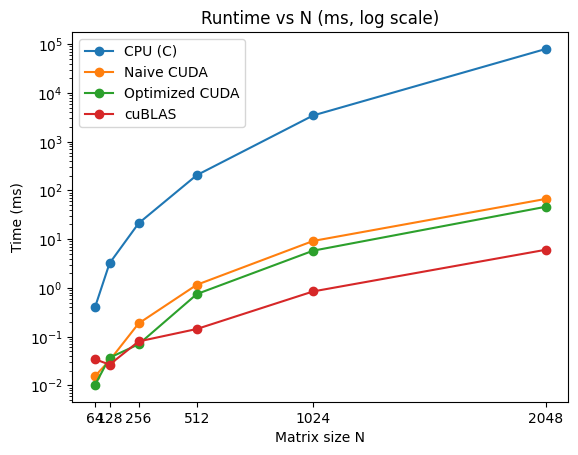

In [ ]:
cublas_ms = df.loc['cuBLAS'].str.replace(' ms','', regex=False).astype(float)

plt.figure()
plt.plot(n_list, cpu_ms.values, marker='o')
plt.plot(n_list, naive_ms.values, marker='o')
plt.plot(n_list, optimized_ms.values, marker='o')
plt.plot(n_list, cublas_ms.values, marker='o')
plt.xlabel('Matrix size N')
plt.ylabel('Time (ms)')
plt.yscale('log')
plt.xticks(n_list)
plt.legend(['CPU (C)', 'Naive CUDA', 'Optimized CUDA', 'cuBLAS' ])
plt.title('Runtime vs N (ms, log scale)')
plt.show()

## Part 7: Analysis Questions

1. How does performance change as matrix size increases? 
2. At what point does the GPU significantly outperform the CPU? 
3. How much speedup is gained by tiling optimization vs. naïve CUDA? 
4. How close is your optimized kernel to cuBLAS performance? 
5. Why might cuBLAS still outperform hand-written kernels?

## Part 7: Creating a Shared Library and Using it in Python

In [ ]:
%%writefile matrix_lib.cu
#include <cuda_runtime.h> 
#include <stdio.h> 
#define TILE_WIDTH 16 

__global__ void matrixMultiplyTiled(float *A, float *B, float *C, int N) { 
    __shared__ float ds_A[TILE_WIDTH][TILE_WIDTH]; 
    __shared__ float ds_B[TILE_WIDTH][TILE_WIDTH]; 

    int bx = blockIdx.x; int by = blockIdx.y; 
    int tx = threadIdx.x; int ty = threadIdx.y; 

    int Row = by * TILE_WIDTH + ty; 
    int Col = bx * TILE_WIDTH + tx; 

    float Pvalue = 0.0; 
    for (int m = 0; m < (N + TILE_WIDTH - 1) / TILE_WIDTH; ++m) { 
        if (Row < N && (m*TILE_WIDTH+tx) < N) 
            ds_A[ty][tx] = A[Row * N + m * TILE_WIDTH + tx]; 
        else 
            ds_A[ty][tx] = 0.0f; 
 
        if (Col < N && (m*TILE_WIDTH+ty) < N) 
            ds_B[ty][tx] = B[(m*TILE_WIDTH + ty) * N + Col]; 
        else 
            ds_B[ty][tx] = 0.0f; 

        __syncthreads(); 
 
        for (int k = 0; k < TILE_WIDTH; ++k) 
            Pvalue += ds_A[ty][k] * ds_B[k][tx]; 
        __syncthreads(); 
    } 
    
    if (Row < N && Col < N) 
        C[Row * N + Col] = Pvalue; 
} 

// Exposed C function for Python 
extern "C" void gpu_matrix_multiply(float *h_A, float *h_B, float *h_C, int N) { 
    size_t size = N * N * sizeof(float); 
    float *d_A, *d_B, *d_C; 
    
    cudaMalloc((void**)&d_A, size); 
    cudaMalloc((void**)&d_B, size); 
    cudaMalloc((void**)&d_C, size); 
 
    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice); 
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice); 

    dim3 dimBlock(TILE_WIDTH, TILE_WIDTH); 
    dim3 dimGrid((N + TILE_WIDTH - 1) / TILE_WIDTH, (N + TILE_WIDTH - 1) / TILE_WIDTH); 

    matrixMultiplyTiled<<<dimGrid, dimBlock>>>(d_A, d_B, d_C, N); 
    cudaDeviceSynchronize(); 
    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost); 
    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C); 
}

Writing matrix_lib.cu


In [ ]:
!nvcc -Xcompiler -fPIC -shared matrix_lib.cu -o libmatrix.so

In [ ]:
import ctypes 
import numpy as np 
import time 

# Load shared library 
lib = ctypes.cdll.LoadLibrary("./libmatrix.so") 

# Define argument types 
lib.gpu_matrix_multiply.argtypes = [ 
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags="C_CONTIGUOUS"), 
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags="C_CONTIGUOUS"), 
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags="C_CONTIGUOUS"), 
    ctypes.c_int 
] 

N = 1024 
A = np.random.rand(N, N).astype(np.float32) 
B = np.random.rand(N, N).astype(np.float32) 
C = np.zeros((N, N), dtype=np.float32) 

start = time.time() 
lib.gpu_matrix_multiply(A.ravel(), B.ravel(), C.ravel(), N) 
end = time.time() 

print(f"Python call to CUDA library completed in {end - start:.4f} seconds") 


Python call to CUDA library completed in 0.1071 seconds
